# DO LEFT-HANDED PEOPLE REALLY DIE YOUNG ?


### by Yueh-Han Chen

## Data Wrangling

### Gather

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
#load data
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)

# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# load death distribution data
death_distribution_data = pd.read_csv(data_url_2, sep='\t',skiprows=[1])

### Data Cleaning

**missing values in death_distribution_data**

**Define: drop NaN values from the `Both Sexes` column**

#### Code

In [4]:
death_distribution_data.dropna(subset=['Both Sexes'],inplace=True)

# EDA

In [6]:
# Since the rate of left-handedness is affected by the birth year, so I gonna create a column called: birth_year
lefthanded_data['birth_year'] = 1986-lefthanded_data['Age']

# And find out the average number of left-handedness
lefthanded_data['mean_l'] = (lefthanded_data['Male']+lefthanded_data['Female'])/2

In [7]:
# find out the birht-year of each age in the death_distribution_data so that we can map the rate of left_handedness
# into the death_distribution_data
death_distribution_data['birth_year'] = 1999 - death_distribution_data['Age']
death_distribution_data['left_handedness'] = 0
early_average= lefthanded_data.tail(10).mean_l.mean()
late_average= lefthanded_data.head(10).mean_l.mean()
for i in list(death_distribution_data['birth_year']):
    index = list(death_distribution_data[death_distribution_data['birth_year']==i].index)[0]
    if i < 1900:
        death_distribution_data['left_handedness'][index:index+1] = early_average
    elif i > 1976:
        death_distribution_data['left_handedness'][index:index+1] = late_average
    else:
        death_distribution_data['left_handedness'][index:index+1] = lefthanded_data[lefthanded_data['birth_year']==i].mean_l.mean()
# I found out this if loop will miss the index 117, because I remove the mssing value before this operation, 
# so I add the rate manually.
death_distribution_data['left_handedness'][116:117+1] = early_average

In [8]:
# find out the rate of right_handedness
death_distribution_data['right_handedness'] = 100-death_distribution_data['left_handedness']
# find out the death number of left_handedness so that I can calcualte the left_handedness_death_rate later
death_distribution_data['left_handedness_death'] = death_distribution_data['Both Sexes']*death_distribution_data['left_handedness']/100
# find out the death number of right_handedness so that I can calcualte the right_handedness_death_rate later
death_distribution_data['right_handedness_death'] = death_distribution_data['Both Sexes']*death_distribution_data['right_handedness']/100
# calcualte the left_handedness_death_rate
death_distribution_data['left_handedness_death_rate'] = death_distribution_data['left_handedness_death']/death_distribution_data['left_handedness_death'].sum()
# calcualte the right_handedness_death_rate
death_distribution_data['right_handedness_death_rate'] = death_distribution_data['right_handedness_death']/death_distribution_data['right_handedness_death'].sum()

## Hypothesis Testing

> **H0: RH's average dead age - LH's average dead age == 9**

> **H1: RH's average dead age - LH's average dead age != 9**

In [9]:
# calculate the average dead age of right_handedness_death_rate and left_handedness_death_rate
print('Average dead age of right handedness:' ,(death_distribution_data['right_handedness_death_rate']*death_distribution_data['Age']).sum())
print('Average dead age of left handedness:' ,(death_distribution_data['left_handedness_death_rate']*death_distribution_data['Age']).sum())
print("Difference: ",(death_distribution_data['right_handedness_death_rate']*death_distribution_data['Age']).sum()-(death_distribution_data['left_handedness_death_rate']*death_distribution_data['Age']).sum(), " years")

Average dead age of right handedness: 72.81669680889921
Average dead age of left handedness: 67.69702073317897
Difference:  5.1196760757202355  years


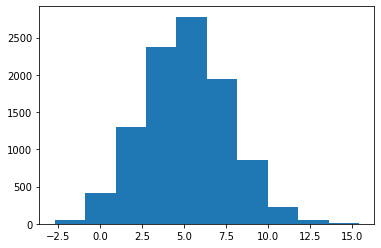

In [28]:
# computed the observed difference
obs_diff = (death_distribution_data['right_handedness_death_rate']*death_distribution_data['Age']).sum()-(death_distribution_data['left_handedness_death_rate']*death_distribution_data['Age']).sum()

# bootstrapped the sampling distribution for the difference
sample_diff=[]
for i in range(10000):
    sample = death_distribution_data.sample(120, replace=True).sort_values('Age')
    rh_da = (sample['right_handedness_death_rate']*sample['Age']).sum()
    lh_da = (sample['left_handedness_death_rate']*sample['Age']).sum()
    sample_diff.append(rh_da-lh_da)
    
plt.hist(sample_diff);

In [29]:
# find its std
std_sampling = np.std(sample_diff)
std_sampling

2.518941319736359

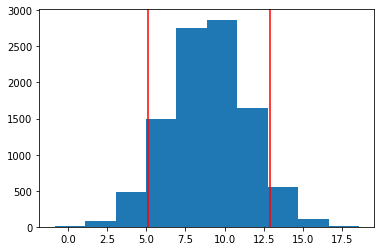

In [44]:
#simulate the distribution under the null hypothesis, 
#by creating a random normal distribution centered at 9 with the same spread and size.
null_vals = np.random.normal(9, std_sampling, len(sample_diff))
plt.hist(null_vals);
plt.axvline(x=obs_diff, color = 'red');
plt.axvline(x=(9+9-obs_diff), color = 'red');

In [31]:
# alpha = 0.05 
# compute the p-value 
((null_vals < obs_diff).mean()+(null_vals > (9+9-obs_diff)).mean()).mean()

0.12209999999999999

## Conclusion 

> I fail to reject the null hypothesis, because We don't have enough evidence to say that right-handed people average dead age minus right-handed people's dead age is not equal to 9 years.